In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os 
os.chdir('/content/drive/My Drive/Jobs/Nk_ref')

Mounted at /content/drive


In [2]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from pandas.plotting import scatter_matrix
from sklearn import svm

%matplotlib inline

seed = 42

df=pd.read_csv("kag_risk_factors_cervical_cancer.csv")
len(df)

858

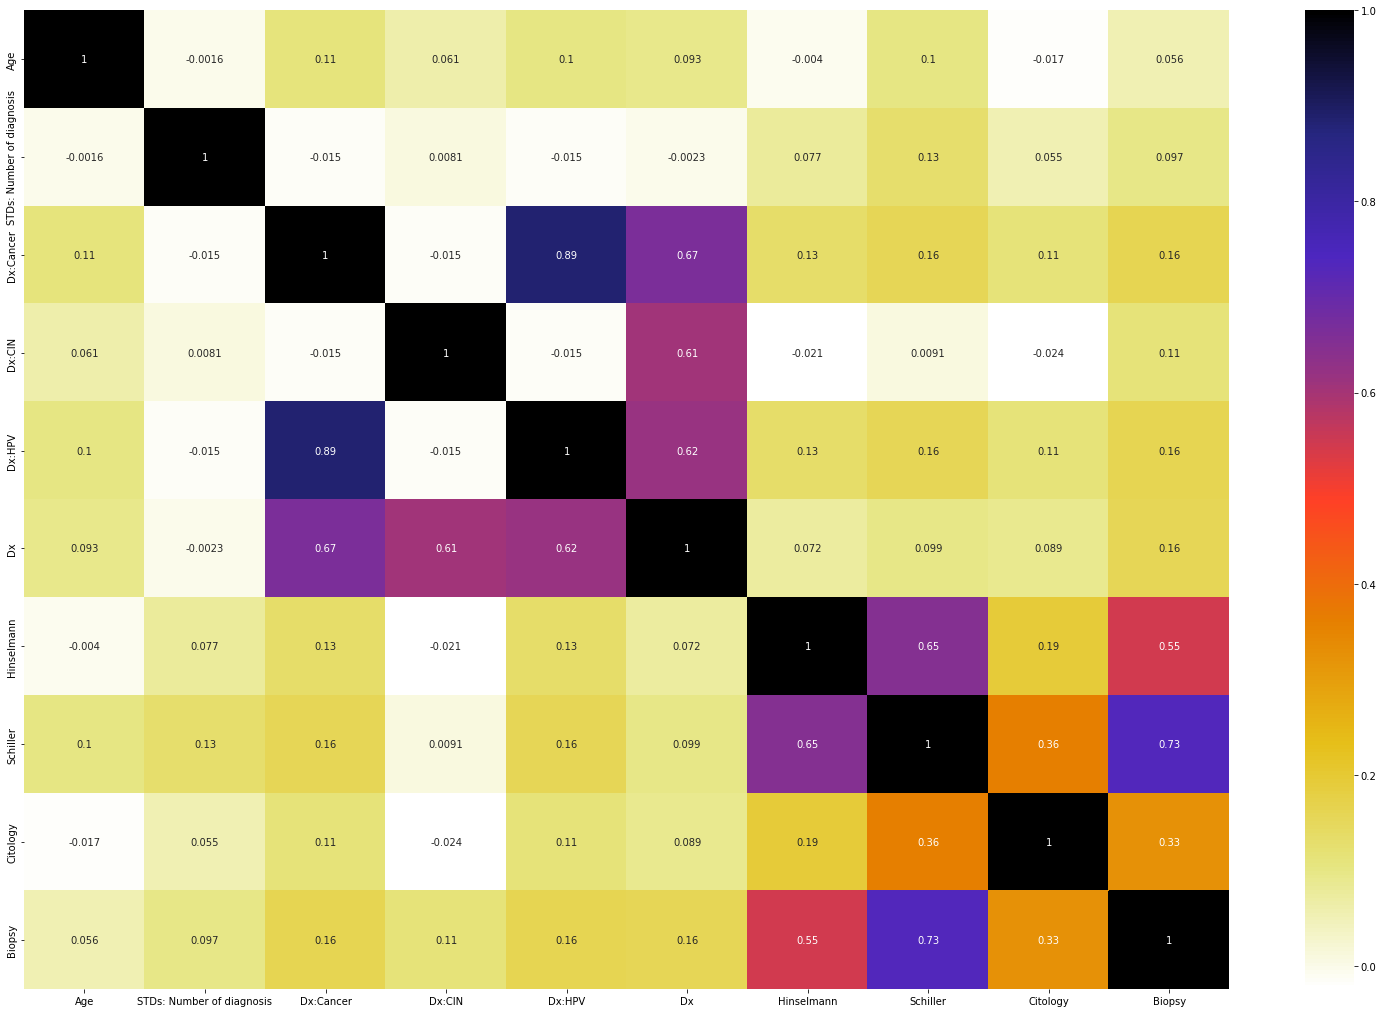

In [67]:
import seaborn as sns

plt.figure(figsize=(27,18))
corr = df.corr()
sns.heatmap(corr, annot=True,cmap=plt.cm.CMRmap_r)
plt.show()

In [68]:
df.shape

(858, 36)

In [69]:
df.Biopsy.value_counts()

0    803
1     55
Name: Biopsy, dtype: int64

In [70]:
len(df.isnull().sum())

36

In [71]:
df.duplicated().sum()

23

In [72]:
df = df.drop_duplicates()

In [73]:
df = df.drop(['Dx:HPV','STDs:Hepatitis B', 'STDs:AIDS','STDs:pelvic inflammatory disease','STDs:vaginal condylomatosis','Dx:CIN','STDs:cervical condylomatosis','STDs:molluscum contagiosum','STDs:HPV','STDs:syphilis','STDs:vulvo-perineal condylomatosis','STDs','Dx:Cancer','STDs:condylomatosis', 'STDs:HIV'], axis=1)

In [74]:
df.shape

(835, 21)

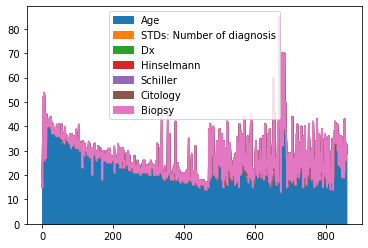

In [75]:
df.plot.area()

In [76]:
#Replace ?s with -1 to represent missing values
df=df.replace("?", 0)
# imp = Imputer(missing_values="?", strategy='most_frequent', axis=0)
# imp.fit(df)
# df = imp.transform(df)

In [77]:
#Split data into training and testing sets
y=df["Biopsy"]
X=df.drop(["Biopsy"], axis=1)
#20% of dataset goes to test set

In [78]:
from imblearn.over_sampling import SMOTE
sm = SMOTE()

x_train_aug, y_train_aug = sm.fit_resample(X,y)

In [79]:
from collections import Counter
print('Before SMOTE: ',Counter(y))
print('After SMOTE: ',Counter(y_train_aug))

Before SMOTE:  Counter({0: 781, 1: 54})
After SMOTE:  Counter({0: 781, 1: 781})


In [80]:
y_train_aug = y_train_aug.to_frame(name='Biopsy')
x_train_aug['Biopsy'] = y_train_aug['Biopsy']
x_train_aug.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs (number),STDs:genital herpes,STDs: Number of diagnosis,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0,0,0,0,0
2,34,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,0.0,0.0,0,0.0,0.0,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,0.0,0.0,0,0.0,0.0,0,0,0,0,0


In [81]:
x_train_aug.duplicated().sum()

11

In [82]:
x_train_aug = x_train_aug.drop_duplicates()
x_train_aug.duplicated().sum()

0

In [83]:
X = x_train_aug.drop('Biopsy', axis=1)
y = x_train_aug['Biopsy']

In [84]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

In [85]:
#Standardize the data
X_scaled = preprocessing.scale(X_train)

In [86]:
X_scaled.mean()

2.1201678405744926e-17

In [87]:
X_scaled.std()

1.0

In [88]:
#Train the random forest classifier using training data
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier(random_state=seed)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [89]:
#Evaluating the classifier using training set
from sklearn.metrics import accuracy_score
y_pred=rfc.predict(X_test)
accuracy_score(y_pred, y_test)


0.9742765273311897

In [90]:
from sklearn.metrics import classification_report

print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       156
           1       0.97      0.98      0.97       155

    accuracy                           0.97       311
   macro avg       0.97      0.97      0.97       311
weighted avg       0.97      0.97      0.97       311



In [107]:
import pickle

# create an iterator object with write permission - model.pkl
with open('./RandomForest-97.pkl', 'wb') as files:
    pickle.dump(rfc, files)

In [91]:
#Evaulating which features the classifier finds important for making its decisions
feats = rfc.feature_importances_

#Create new instance of dataframe
feat_importances=pd.DataFrame()

#set columns in datafram to features and their importances
feat_importances["feature"]=X.columns
feat_importances["rfc"]=feats

#Display data
feat_importances.sort_values('rfc')

,feature,rfc
16,Dx,0.004044
13,STDs: Number of diagnosis,0.004194
12,STDs:genital herpes,0.005077
5,Smokes (years),0.006800
6,Smokes (packs/year),0.008412
4,Smokes,0.009721
10,IUD (years),0.009999
14,STDs: Time since first diagnosis,0.011119
15,STDs: Time since last diagnosis,0.011357
19,Citology,0.011477


In [92]:
X_train.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,IUD (years),STDs (number),STDs:genital herpes,STDs: Number of diagnosis,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx,Hinselmann,Schiller,Citology
329,31,1.0,17.0,5.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0,0
398,17,3.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0,0
712,30,2.0,18.0,3.0,0.0,0.0,0.0,1.0,8.0,1.0,0.5,0.0,0.0,0,0.0,0.0,0,0,0,0
1290,33,2.119443,23.402785,2.559721,0.0,0.0,0.0,1.0,0.309695,0.559721,1.679164,0.0,0.0,0,0.0,0.0,0,0,1,0
163,29,0.0,19.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0,0


In [94]:
X_train.columns

Index(['Age', 'Number of sexual partners', 'First sexual intercourse',
       'Num of pregnancies', 'Smokes', 'Smokes (years)', 'Smokes (packs/year)',
       'Hormonal Contraceptives', 'Hormonal Contraceptives (years)', 'IUD',
       'IUD (years)', 'STDs (number)', 'STDs:genital herpes',
       'STDs: Number of diagnosis', 'STDs: Time since first diagnosis',
       'STDs: Time since last diagnosis', 'Dx', 'Hinselmann', 'Schiller',
       'Citology'],
      dtype='object')

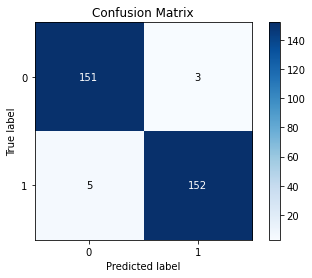

In [95]:
skplt.metrics.plot_confusion_matrix(y_true=y_test, y_pred=y_pred)
plt.show()

In [96]:
np.sum(y_test.values==1), np.sum(y_test.values==0)

(157, 154)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=FutureWarning)


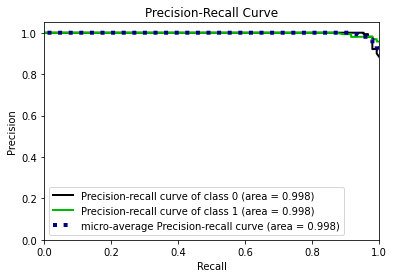

In [97]:
skplt.metrics.plot_precision_recall_curve(y_true=y_test, y_probas=rfc.predict_proba(X_test))
plt.show()

In [98]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       154
           1       0.98      0.97      0.97       157

    accuracy                           0.97       311
   macro avg       0.97      0.97      0.97       311
weighted avg       0.97      0.97      0.97       311



In [99]:
#Train the random forest classifier using training data
from sklearn.ensemble import RandomForestClassifier
rfcw=RandomForestClassifier(random_state=seed, class_weight={0:20, 1:0.5})
rfcw.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 20, 1: 0.5}, random_state=42)

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       154
           1       0.98      0.97      0.98       157

    accuracy                           0.98       311
   macro avg       0.98      0.98      0.98       311
weighted avg       0.98      0.98      0.98       311



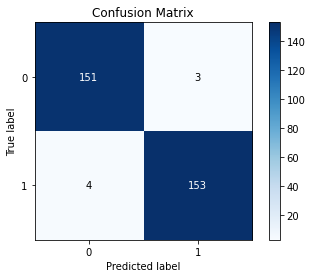

In [100]:
rfcw_pred = rfcw.predict(X_test)
print(classification_report(y_test, rfcw_pred))
skplt.metrics.plot_confusion_matrix(y_true=y_test, y_pred=rfcw_pred)
plt.show()

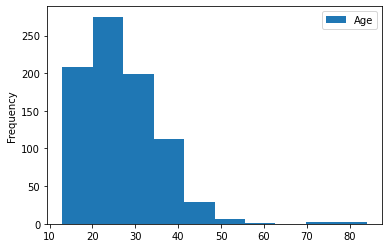

In [101]:
df.plot.hist(x="Biopsy", y="Age")

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


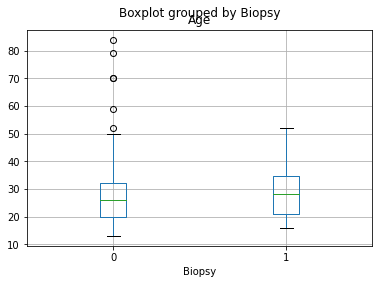

In [102]:
df.boxplot(column="Age", by="Biopsy")

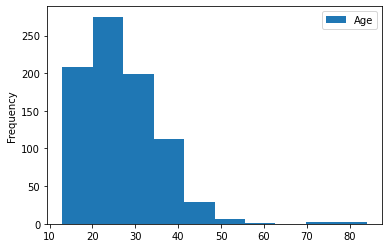

In [103]:
df.plot.hist(x="Biopsy", y="Age")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5f045670a0>]],
      dtype=object)

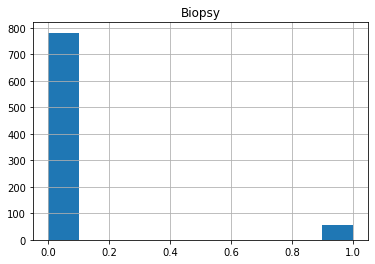

In [104]:
df.hist(column="Biopsy")

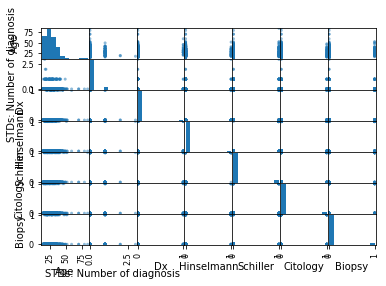

In [105]:
scatter_matrix(df)
plt.show()

In [106]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import numpy as np

classifiers = [
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1, random_state=42),
    ]

names = ["Linear SVC", "SVC", "RFC"]


clfs = list(zip(classifiers, names))

for clf, n in clfs:
    clf.fit(X_train, y_train)
    preds = np.rint(clf.predict(X_test))
    print(n, accuracy_score(y_test, preds))

vclf = VotingClassifier(estimators=clfs, voting="hard")

Linear SVC 0.8520900321543409
SVC 0.8360128617363344
RFC 0.8070739549839229


NameError: ignored

ValueError: Found input variables with inconsistent numbers of samples: [686, 858]

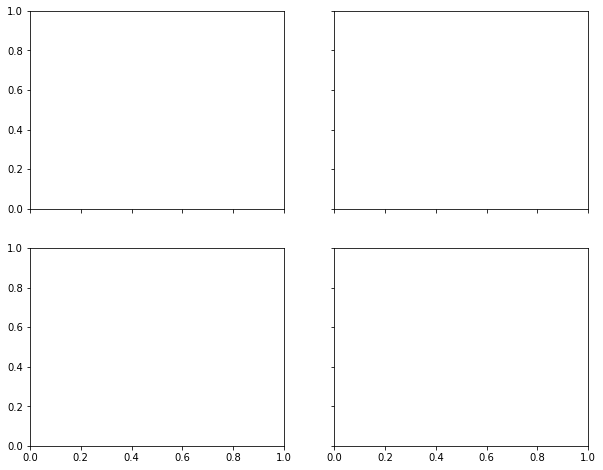

In [ ]:
from sklearn.decomposition import PCA
from sklearn.gaussian_process.kernels import Product
from itertools import product

pca = PCA(n_components=2)

pca.fit(X_train)

X_train2d = pca.transform(X_train)

# Plotting decision regions
x_min, x_max = X_train2d[:, 0].min() - 1, X_train2d[:, 0].max() + 1
y_min, y_max = X_train2d[:, 1].min() - 1, X_train2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        classifiers,
                        names):

    clf.fit(X_train2d, y)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(X[:, 0], X[:, 1], c=y,
                                  s=20, edgecolor='k')
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

In [ ]:
#Train the SVM using training data
svmc=svm.SVC()
svmc.fit(X_train, y_train)

C:\Users\ABDULSHAKUR GALLA\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       161
           1       0.00      0.00      0.00        11

    accuracy                           0.94       172
   macro avg       0.47      0.50      0.48       172
weighted avg       0.88      0.94      0.91       172



C:\Users\ABDULSHAKUR GALLA\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


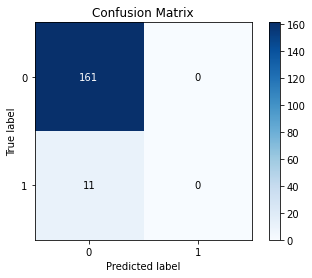

0.9418604651162791

In [ ]:
svmc_pred = svmc.predict(X_test)
print(classification_report(y_test, svmc_pred))
skplt.metrics.plot_confusion_matrix(y_true=y_test, y_pred=svmc_pred)
plt.show()#Evaluating the classifier using training set
from sklearn.metrics import accuracy_score
y_pred=rfc.predict(X_test)
accuracy_score(y_pred, y_test)

In [ ]:
#Evaluating the classifier using training set
from sklearn.metrics import accuracy_score
y_pred=rfc.predict(X_test)
accuracy_score(y_pred, y_test)

0.9418604651162791

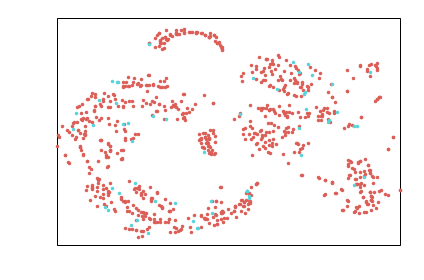

In [ ]:
from sklearn import datasets
import hypertools as hyp

hyp.plot(X, '.', reduce='TSNE', group=y, ndims=2)
# hyp.plot(X, '.', reduce='TSNE', n_clusters=10, ndims=2)